In [62]:
using BioAlignments
using FASTX
using ProgressMeter
using Printf
using CSV
using Plots
using StatsPlots
using StatsBase
using Distributions
include("source/utils.jl")
include("source/io.jl")
include("source/alignment.jl")
include("source/pctid.jl")
include("source/gumbel.jl");

## Data prep

In [2]:
sprot = readsequences("data/sprot.fa")
filter!(x -> 280 <= length(x) < 320, sprot)
writesequences("data/sprot300.fa", sprot)
rev_sprot = reverse.(sprot)
writesequences("data/rev_sprot300.fa", rev_sprot)
shuf_sprot = shufflefast.(sprot)
writesequences("data/shuf_sprot300.fa", shuf_sprot)
rev_shuf_sprot = reverse.(shuf_sprot)
writesequences("data/rev_shuf_sprot300.fa", rev_shuf_sprot)

In [3]:
masked_sprot = readsequences("data/masked_sprot.fa")
filter!(x -> 280 <= length(x) < 320, masked_sprot)
masked_sprot = replace.(masked_sprot, 'X'=>"")
writesequences("data/masked_sprot300.fa", masked_sprot)
rev_masked_sprot = reverse.(masked_sprot)
writesequences("data/rev_masked_sprot300.fa", rev_masked_sprot)
shuf_masked_sprot = shufflefast.(masked_sprot)
writesequences("data/shuf_masked_sprot300.fa", shuf_masked_sprot)
rev_shuf_masked_sprot = reverse.(shuf_masked_sprot)
writesequences("data/rev_shuf_masked_sprot300.fa", rev_shuf_masked_sprot);

## Align for score

In [4]:
alignmentscore(x1, x2) = align(Pairwise(), x1, x2;
    formatter=x::PairwiseAlignmentResult -> score(x)::Int,
    verbose=true)

alignmentscore (generic function with 1 method)

In [5]:
sprot = readsequences("data/sprot300.fa")
rev_sprot = readsequences("data/rev_sprot300.fa")
shuf_sprot = readsequences("data/shuf_sprot300.fa")
rev_shuf_sprot = readsequences("data/rev_shuf_sprot300.fa")
masked_sprot = readsequences("data/masked_sprot300.fa")
rev_masked_sprot = readsequences("data/rev_masked_sprot300.fa")
shuf_masked_sprot = readsequences("data/shuf_masked_sprot300.fa")
rev_shuf_masked_sprot = readsequences("data/rev_shuf_masked_sprot300.fa");

In [6]:
scores_shuf = alignmentscore(sprot, shuf_sprot);

Aligning... 100%|████████████████████████████████████████| Time: 0:00:07


In [7]:
scores_rev = alignmentscore(sprot, rev_sprot);

Aligning... 100%|████████████████████████████████████████| Time: 0:00:05


In [8]:
scores_shufrev = alignmentscore(shuf_sprot, rev_shuf_sprot);

Aligning... 100%|████████████████████████████████████████| Time: 0:00:06


In [9]:
scores_maskedshuf = alignmentscore(masked_sprot, shuf_masked_sprot);

Aligning... 100%|████████████████████████████████████████| Time: 0:00:05


In [10]:
scores_maskedrev = alignmentscore(masked_sprot, rev_masked_sprot);

Aligning... 100%|████████████████████████████████████████| Time: 0:00:06


In [11]:
scores_maskedshufrev = alignmentscore(shuf_masked_sprot, rev_shuf_masked_sprot);

Aligning... 100%|████████████████████████████████████████| Time: 0:00:05


## Plot Scores

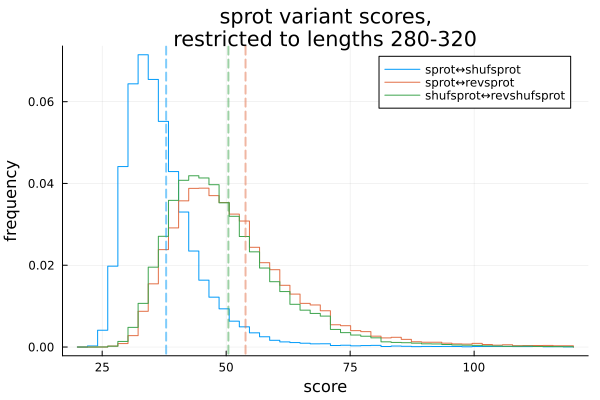

In [12]:
colors=theme_palette(:auto);
plot(title="sprot variant scores,\nrestricted to lengths 280-320",xlabel="score",ylabel="frequency")
stephist!(scores_shuf, norm=true, bins=range(20,120,50), label="sprot↔shufsprot")
stephist!(scores_rev, norm=true, bins=range(20,120,50), label="sprot↔revsprot")
stephist!(scores_shufrev, norm=true, bins=range(20,120,50), label="shufsprot↔revshufsprot")
vline!([mean(scores_shuf)],label=false,color=colors[1],width=2,linestyle=:dash,alpha=0.5)
vline!([mean(scores_rev)],label=false,color=colors[2],width=2,linestyle=:dash,alpha=0.5)
vline!([mean(scores_shufrev)],label=false,color=colors[3],width=2,linestyle=:dash,alpha=0.5)

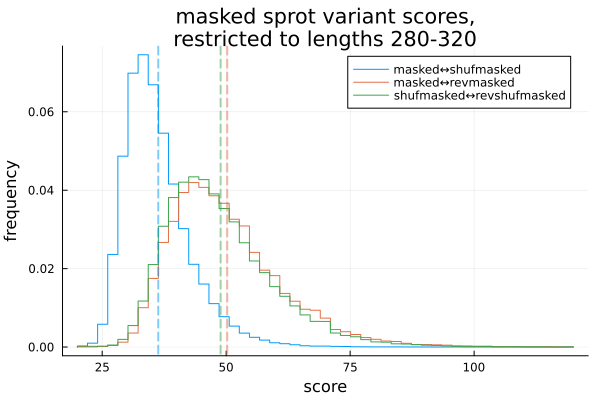

In [13]:
plot(title="masked sprot variant scores,\nrestricted to lengths 280-320",xlabel="score",ylabel="frequency")
stephist!(scores_maskedshuf, norm=true, bins=range(20,120,50), label="masked↔shufmasked")
stephist!(scores_maskedrev, norm=true, bins=range(20,120,50), label="masked↔revmasked")
stephist!(scores_maskedshufrev, norm=true, bins=range(20,120,50), label="shufmasked↔revshufmasked")
vline!([mean(scores_maskedshuf)],label=false,color=colors[1],width=2,linestyle=:dash,alpha=0.5)
vline!([mean(scores_maskedrev)],label=false,color=colors[2],width=2,linestyle=:dash,alpha=0.5)
vline!([mean(scores_maskedshufrev)],label=false,color=colors[3],width=2,linestyle=:dash,alpha=0.5)

## Fit Gumbel Distributions to Score Data

For general information on Gumbel distributions:

https://en.wikipedia.org/wiki/Gumbel_distribution

For details on the particular type we are constructing:

https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Gumbel

Because `Distributions.jl` doesn't seem to support fitting Gumbel distributions, I made a quick implementation of `fit(Gumbel, data)` using the code published in this blog:

https://djalil.chafai.net/blog/2018/02/18/gumbel-fit-with-julia/

In [64]:
gumbel_shuf = fit(Gumbel, scores_shuf)
gumbel_rev = fit(Gumbel, scores_rev)
gumbel_shufrev = fit(Gumbel, scores_shufrev);

In [65]:
gumbel_maskedshuf = fit(Gumbel, scores_maskedshuf)
gumbel_maskedrev = fit(Gumbel, scores_maskedrev)
gumbel_maskedshufrev = fit(Gumbel, scores_maskedshufrev);